*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

In Module 1, we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories 
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [1]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=0fc53801bdc7b2e2f51cad5d96403f2b98a70e88018d32605547eceb0acd4868
  Stored in directory: /tmp/pip-ephem-wheel-cache-22qeca9u/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [1]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2021-12-02 17:27:43--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     149  --.-KB/s    in 0s      

2021-12-02 17:27:43 (4.80 MB/s) - ‘requirements.txt’ saved [149/149]

     |████████████████████████████████| 24.2 MB 352 kB/s 
     |████████████████████████████████| 1.6 MB 42.6 MB/s 
     |████████████████████████████████| 10.4 MB 24.9 MB/s 
     |████████████████████████████████| 7.1 MB 644 kB/s 
     |████████████████████████████████| 208 kB 60.0 MB/s 
     |████████████████████████████████| 2.2 MB 41.2 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py

##1.0.3 Imports and such

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Part 1: Building a Latent Dirichlet Allocation (LDA) Topic Model with Gensim

Our goal in this module is to get hands-on experience in how to build and train a Latent Dirichlet Allocation topic model using the **Gensim** library. 

## 1.1 Latent Dirichlet Allocation (LDA) 
is a more sophisticated method of topic modelling than Latent Semantic Indexing (LSI) which we used in Module 2. Because of its complexity, a full discussion of the machinery of LDA is beyond the scope of Unit 4. We'll focus on a high level of understanding of Latent Dirichlet Allocation, meaning we'll emphasize "what it does" rather than "how it does it". 

LDA takes as input the corpora of documents and the number of topics that you want to identify. LDA models topics as probability distributions over words, and it models documents as probability distributions over topics.

LDA is a generative probabilistic model. That means it can generate documents from probability distributions. Given an article length (number of words), an assumed probability distribution of topics, and an assumed distribution of words for each topic, LDA can generate an article, in the form of a bag of words. LDA works by starting with random distributions of words over topics and  topics over documents, then iteratively adjust these probability distributions until the generated documents are similar in structure to the input documents.





### 1.1.1 Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended Medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/) is an interactive data visualization tool -- created by the author of the above article -- that allows us to explore a simple and visual example of LDA.

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) disccusses an example implementing LDA using the same dataset that we are using in this guided project.  

Luis Serrano's video [**Latent Dirichlet Allocation**](https://youtu.be/T05t-SqKArY) does a great job of breaking down and explaining LDA in an understandable way.



### 1.1.2 Further discussion of LDA (Optional)

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

A PGM can be represented by a graph that expresses the conditional dependence structure between random variables. Here's a graphical representation of the LDA model: 

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

The image shows the hierarchical dependency between probability distributions and their parameters. This is an application of Hierarchical Bayesian Modeling. 

In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources: 

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using four popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

[**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning. 

## 1.2 Preparing our text data set for LDA topic modeling with `gensim`
For this guided project we'll work with the `20newsgroups` data set that is  familiar from Module 3, but we'll extract articles from a different set of categories.<br><br>
`gensim` is a Natural Language Processing Library, specialized for Topic Modeling applications. The two main inputs required for a `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.<br><br>
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br><br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`.<br>

In this section, we will first download and clean the raw text documents, then use `spacy` to tokenize and lemmatize them. Then we'll use `gensim` to create the `id2word` and `corpus` objects that we need for topic modeling with `gensim`<br>

In Part 2, we'll build and train the LDA topic model in `gensim`.

References: 
- [Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

# Problem Statement



We'll extract articles belonging to the following four topics (as assigned in the 20newsgroups database)

    sci
        \_ electronics, space


    talk
        \_politics 
                  \_ guns, middle east
              
What's the best way to categorize these emails - is it between science and talk? 

Or it between electronics, space, guns, and the Middle East? 

The Middle East is a pretty broad topic in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer these questions!

### Load Email Corpus


In [3]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics  
categories = ['sci.electronics', 'sci.space', 
              'talk.politics.guns', 'talk.politics.mideast']
data = fetch_20newsgroups(subset='all', 
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

In [5]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [7]:
# create X and y from data, as we did in the Module 3 Lecture notebook

###BEGIN SOLUTION
X = data.data
y = data.target
target_names = data.target_names
###END SOLUTION

What are the possible targets (labels)

In [8]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [9]:
target_names

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [10]:
data_dict = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data_dict)

In [11]:
df.head()

,content,target,target_names
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns
2,==========================\n ...,1,sci.space
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns


In [12]:
len(df)

3821

Re-use our `clean_data()` helper function from Module 3.

In [13]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

Clean the text string data and save it in a new column

In [14]:
df["clean_data"] = df["content"].apply(clean_data)

In [15]:
df.head()

,content,target,target_names,clean_data
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,some of the davidians are black next question
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,how about firearm related texas is unusual in ...
2,==========================\n ...,1,sci.space,ozone gif images april two gif images of the o...
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,from phil g fraering pgf srl cacs usl edu fina...
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article hydra gatech edu by gs prism gate...


### Create Tokens 

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens. 

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [16]:
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=10)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_md")

In [18]:
%%time
# create our tokens in the form of lemmas 
# parallel_apply takes about 2 min on Colab
#df['lemmas'] = df['clean_data'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])
# parallel_map takes about 50 sec
df['lemmas'] = df['clean_data'].parallel_map(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])


CPU times: user 3.56 s, sys: 735 ms, total: 4.29 s
Wall time: 1min 16s


### Take a look at our lemmas

In [19]:
df['clean_data'][5]

'from gene wright gene theporch raider net i ll say imagine that there were a couple groups up there maybe landing a few weeks apart the year mark starts coming on for the first group isn t a billion pretty good incentive to take a shot at a potential winner yeah that s a shame that team a s life support gave out so close to the deadline thanks for the billion on the other hand if apollo cost billion for a few days or weeks in space in dollars then won t the reward have to be a lot more than only billion to get any takers tommy mac tom mcwilliams wk as the radius of vision increases tm ibm cl msu edu hm the circumference of mystery grows'

In [20]:
# print out the lemmas from the first article
# note that some lemmas are only 1 character: you could modify the code above to not include lemmas that are only 1 or 2 characters
df['lemmas'][5]

['gene',
 'wright',
 'gene',
 'theporch',
 'raider',
 'net',
 'will',
 'imagine',
 'couple',
 'group',
 'maybe',
 'land',
 'week',
 'apart',
 'year',
 'mark',
 'start',
 'come',
 'group',
 'isn',
 't',
 'billion',
 'pretty',
 'good',
 'incentive',
 'shot',
 'potential',
 'winner',
 'yeah',
 's',
 'shame',
 'team',
 's',
 'life',
 'support',
 'give',
 'close',
 'deadline',
 'thank',
 'billion',
 'hand',
 'apollo',
 'cost',
 'billion',
 'day',
 'week',
 'space',
 'dollar',
 'win',
 't',
 'reward',
 'lot',
 'billion',
 'taker',
 'tommy',
 'mac',
 'tom',
 'mcwilliams',
 'wk',
 'radius',
 'vision',
 'increase',
 'tm',
 'ibm',
 'cl',
 'msu',
 'edu',
 'hm',
 'circumference',
 'mystery',
 'grow']

### Filter out low quality lemmas
1 or 2 characters

In [22]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [23]:
# apply filter_lemmas
# YOUR CODE HERE
df["filtered_lemmas"] = df["lemmas"].parallel_map(filter_lemmas)


In [24]:
df["filtered_lemmas"][5]

['gene',
 'wright',
 'gene',
 'theporch',
 'raider',
 'net',
 'will',
 'imagine',
 'couple',
 'group',
 'maybe',
 'land',
 'week',
 'apart',
 'year',
 'mark',
 'start',
 'come',
 'group',
 'isn',
 'billion',
 'pretty',
 'good',
 'incentive',
 'shot',
 'potential',
 'winner',
 'yeah',
 'shame',
 'team',
 'life',
 'support',
 'give',
 'close',
 'deadline',
 'thank',
 'billion',
 'hand',
 'apollo',
 'cost',
 'billion',
 'day',
 'week',
 'space',
 'dollar',
 'win',
 'reward',
 'lot',
 'billion',
 'taker',
 'tommy',
 'mac',
 'tom',
 'mcwilliams',
 'radius',
 'vision',
 'increase',
 'ibm',
 'msu',
 'edu',
 'circumference',
 'mystery',
 'grow']

Overwrite `lemmas` with `filtered_lemmas`

In [25]:
df['lemmas'] = df["filtered_lemmas"]

### The two main inputs to the `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

### Create the `id2word` dictionary

In [26]:
# 1. Create Dictionary

# 2. Term Document Frequency is (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)

### BEGIN SOLUTION
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['lemmas'] )

In [27]:
id2word

Use the `id2word.doc2bow()` method to process a first document into a list of word counts

In [28]:
len(np.unique(df['lemmas'][5]))

57

In [29]:
id2word.doc2bow(df['lemmas'][5])

[(29, 2),
 (35, 1),
 (104, 1),
 (178, 1),
 (179, 1),
 (182, 1),
 (190, 1),
 (202, 1),
 (204, 1),
 (212, 1),
 (213, 1),
 (216, 1),
 (217, 1),
 (220, 1),
 (221, 1),
 (223, 1),
 (224, 1),
 (234, 1),
 (244, 1),
 (245, 1),
 (250, 1),
 (271, 1),
 (272, 1),
 (273, 4),
 (274, 1),
 (275, 1),
 (276, 1),
 (277, 1),
 (278, 1),
 (279, 1),
 (280, 2),
 (281, 1),
 (282, 1),
 (283, 1),
 (284, 1),
 (285, 1),
 (286, 1),
 (287, 1),
 (288, 1),
 (289, 1),
 (290, 1),
 (291, 1),
 (292, 1),
 (293, 1),
 (294, 1),
 (295, 1),
 (296, 1),
 (297, 1),
 (298, 1),
 (299, 1),
 (300, 1),
 (301, 2),
 (302, 1),
 (303, 1),
 (304, 1),
 (305, 1),
 (306, 1)]

### Create the `corpus`
by processing all the documents using a list comprehension

In [30]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['lemmas']]

# corpus stores (token id, token count) for each doc in the corpus
doc_id = 5
corpus[doc_id]

[(29, 2),
 (35, 1),
 (104, 1),
 (178, 1),
 (179, 1),
 (182, 1),
 (190, 1),
 (202, 1),
 (204, 1),
 (212, 1),
 (213, 1),
 (216, 1),
 (217, 1),
 (220, 1),
 (221, 1),
 (223, 1),
 (224, 1),
 (234, 1),
 (244, 1),
 (245, 1),
 (250, 1),
 (271, 1),
 (272, 1),
 (273, 4),
 (274, 1),
 (275, 1),
 (276, 1),
 (277, 1),
 (278, 1),
 (279, 1),
 (280, 2),
 (281, 1),
 (282, 1),
 (283, 1),
 (284, 1),
 (285, 1),
 (286, 1),
 (287, 1),
 (288, 1),
 (289, 1),
 (290, 1),
 (291, 1),
 (292, 1),
 (293, 1),
 (294, 1),
 (295, 1),
 (296, 1),
 (297, 1),
 (298, 1),
 (299, 1),
 (300, 1),
 (301, 2),
 (302, 1),
 (303, 1),
 (304, 1),
 (305, 1),
 (306, 1)]

In [33]:
print(type(corpus))
print(len(corpus))

<class 'list'>
3821


In [34]:

### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[doc_id]]

### END SOLUTION

[('group', 2),
 ('isn', 1),
 ('day', 1),
 ('space', 1),
 ('support', 1),
 ('team', 1),
 ('year', 1),
 ('circumference', 1),
 ('edu', 1),
 ('good', 1),
 ('grow', 1),
 ('ibm', 1),
 ('increase', 1),
 ('mac', 1),
 ('mcwilliams', 1),
 ('msu', 1),
 ('mystery', 1),
 ('radius', 1),
 ('tom', 1),
 ('tommy', 1),
 ('vision', 1),
 ('apart', 1),
 ('apollo', 1),
 ('billion', 4),
 ('close', 1),
 ('come', 1),
 ('cost', 1),
 ('couple', 1),
 ('deadline', 1),
 ('dollar', 1),
 ('gene', 2),
 ('give', 1),
 ('hand', 1),
 ('imagine', 1),
 ('incentive', 1),
 ('land', 1),
 ('life', 1),
 ('lot', 1),
 ('mark', 1),
 ('maybe', 1),
 ('net', 1),
 ('potential', 1),
 ('pretty', 1),
 ('raider', 1),
 ('reward', 1),
 ('shame', 1),
 ('shot', 1),
 ('start', 1),
 ('taker', 1),
 ('thank', 1),
 ('theporch', 1),
 ('week', 2),
 ('will', 1),
 ('win', 1),
 ('winner', 1),
 ('wright', 1),
 ('yeah', 1)]

# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

#### The multi-processor version of gensim's LDA model is `gensim.models.ldamulticore.LdaMulticore()`, <br> which runs faster than the single-core version `gensim.models.ldamodel.LdaModel()`


In [35]:
%%time

num_topics = 2
### This cell runs the multi-processor version of the model (faster)
lda_multicore_2_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

num_topics = 6
### This cell runs the multi-processor version of the model (faster)
lda_multicore_6_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

CPU times: user 33.1 s, sys: 4.47 s, total: 37.6 s
Wall time: 36.1 s


In [ ]:
dir(lda_multicore_6_topics)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'batch',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_al

# Part 3: Interpret LDA results & Select the appropriate number of topics
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>


### 3.1 Visualizing the topics in our models

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.102493  0.0       1        1  51.050126
0     -0.102493  0.0       2        1  48.949874, topic_info=           Term         Freq        Total Category  logprob  loglift
178       space  1267.000000  1267.000000  Default  30.0000  30.0000
807    armenian  1026.000000  1026.000000  Default  29.0000  29.0000
808   armenians   838.000000   838.000000  Default  28.0000  28.0000
50       people  2008.000000  2008.000000  Default  27.0000  27.0000
1860    turkish   635.000000   635.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
489       thing   414.374194   786.932249   Topic2  -6.0979   0.0730
54      problem   366.827671   585.858513   Topic2  -6.2198   0.2462
332        want   421.926833   889.159894   Topic2  -6.0799  -0.0311
219        look   391.767833   747.418120   Topic2  -6.1540   0.0684
405        find   394.427928   788.778681   Topic2  -6.1473   0.0213

[178 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
10932      1  0.006772      adl
10932      2  0.995483      adl
9235       1  0.997647   ankara
9235       2  0.009070   ankara
2046       1  0.011542  antenna
...      ...       ...      ...
1884       2  0.028694    woman
499        1  0.324461     work
499        2  0.676377     work
190        1  0.475309     year
190        2  0.524668     year

[282 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.101261 -0.110004       1        1  32.101905
5     -0.085410 -0.027109       2        1  27.275705
3     -0.170945  0.099628       3        1  18.134426
4     -0.007902 -0.076017       4        1  12.086112
2      0.002979 -0.045161       5        1   8.347957
1      0.160016  0.158663       6        1   2.053895, topic_info=           Term         Freq        Total Category  logprob  loglift
604         gun  1148.000000  1148.000000  Default  30.0000  30.0000
807    armenian  1017.000000  1017.000000  Default  29.0000  29.0000
593      israel   729.000000   729.000000  Default  28.0000  28.0000
808   armenians   818.000000   818.000000  Default  27.0000  27.0000
178       space  1351.000000  1351.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1000       hear    12.117472   457.028707   Topic6  -6.4590   0.2553
433        know    12.569117  1548.218209   Topic6  -6.4224  -0.9282
275        come    12.365800   972.849411   Topic6  -6.4387  -0.4799
18          don    12.019412  1372.782051   Topic6  -6.4671  -0.8526
246         try    11.737117   645.125271   Topic6  -6.4909  -0.1213

[475 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
6572       1  0.069123  accidental
6572       2  0.069123  accidental
6572       3  0.023041  accidental
6572       4  0.852516  accidental
4058       1  0.012169        adam
...      ...       ...         ...
3431       3  0.021255  yugoslavia
25533      3  0.972939     zinaida
2350       2  0.979287     zionism
2351       2  0.935200     zionist
2351       5  0.050100     zionist

[1153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 4, 5, 3, 2])

###3.2 What is topic coherence?


_Topic Coherence measures score a single topic by
measuring the degree of semantic similarity between
high scoring words in the topic._ <br>
-- From "Exploring Topic Coherence over many models and many topics", by Keith Stevens, Philip Kegelmeyer, David Andrzejewski, and David Buttler, Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural
Language Learning, pages 952–961, Jeju Island, Korea, 12–14 July 2012. 
c 2012 Association for Computational Linguistics

_A set of statements or facts is said to be coherent, if they
support each other. Thus, a coherent fact set can be interpreted
in a context that covers all or most of the facts. An
example of a coherent fact set is 'the game is a team sport',
'the game is played with a ball', and 'the game demands great
physical efforts'_ -- from "Exploring the Space of Topic Coherence Measures", by Michael Roder, Andreas Both and Alexander Hinneburg https://dl.acm.org/doi/10.1145/2684822.2685324

We expect that documents in a topic category should be coherent, i.e., they should relate to each other. The same is true for words within a topic.


### Let's tune the "number of topics" hyperparameter 
and choose the model with the best Topic Coherence score.

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=10, step=1)

CPU times: user 2min 42s, sys: 20 s, total: 3min 2s
Wall time: 3min 29s


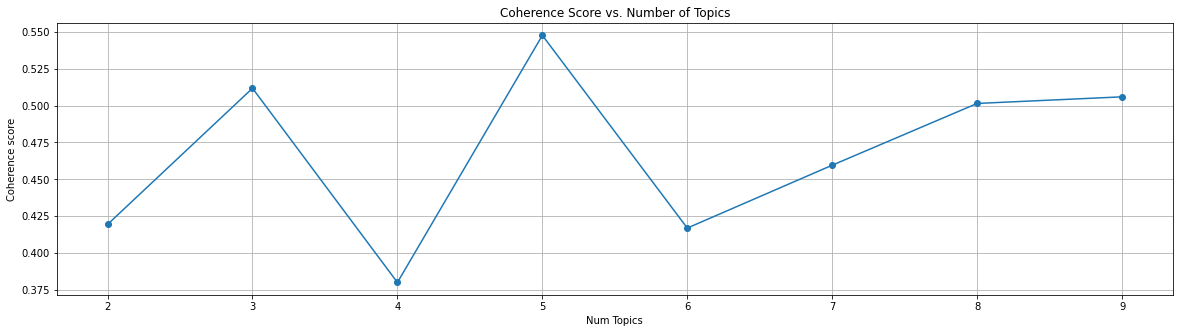

In [40]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

### Select the "best" model as the one with the highest Topic Coherence Score

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus. 

In [41]:
lda_trained_model = model_list[3] 

In [ ]:
lda_trained_model

### For each topic discovered by `gensim`, list the top ten words and their probabilities, 

In [42]:
pprint(lda_trained_model.print_topics())

[(0,
  '0.011*"space" + 0.004*"launch" + 0.004*"use" + 0.004*"system" + '
  '0.004*"like" + 0.004*"time" + 0.004*"know" + 0.004*"nasa" + 0.003*"year" + '
  '0.003*"work"'),
 (1,
  '0.009*"wire" + 0.007*"ground" + 0.005*"circuit" + 0.005*"problem" + '
  '0.004*"battery" + 0.004*"use" + 0.004*"wiring" + 0.003*"outlet" + '
  '0.003*"neutral" + 0.003*"don"'),
 (2,
  '0.011*"say" + 0.011*"people" + 0.009*"israel" + 0.008*"know" + 0.007*"come" '
  '+ 0.007*"think" + 0.007*"don" + 0.005*"right" + 0.005*"israeli" + '
  '0.005*"like"'),
 (3,
  '0.013*"armenian" + 0.009*"armenians" + 0.009*"turkish" + 0.007*"people" + '
  '0.005*"turkey" + 0.005*"armenia" + 0.004*"turks" + 0.004*"genocide" + '
  '0.004*"azerbaijan" + 0.004*"government"'),
 (4,
  '0.012*"gun" + 0.006*"people" + 0.006*"right" + 0.005*"law" + 0.005*"don" + '
  '0.004*"weapon" + 0.004*"know" + 0.004*"think" + 0.004*"like" + '
  '0.004*"time"')]


###Visualize the topics in the best model

In [43]:
# visualize the topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.141027 -0.056959       1        1  31.761079
4      0.027303 -0.089068       2        1  24.582128
2      0.083472 -0.047115       3        1  19.609421
3      0.160681  0.080805       4        1  18.017488
1     -0.130429  0.112337       5        1   6.029884, topic_info=          Term         Freq        Total Category  logprob  loglift
604        gun  1191.000000  1191.000000  Default  30.0000  30.0000
807   armenian   970.000000   970.000000  Default  29.0000  29.0000
178      space  1304.000000  1304.000000  Default  28.0000  28.0000
593     israel   746.000000   746.000000  Default  27.0000  27.0000
1860   turkish   602.000000   602.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
237      right    53.370504  1161.923063   Topic5  -6.0534  -0.2721
405       find    51.140785   791.493802   Topic5  -6.0961   0.0691
499       work    49.083080   808.583548   Topic5  -6.1371   0.0067
433       know    48.793486  1566.553744   Topic5  -6.1430  -0.6606
212       good    47.769374   810.933017   Topic5  -6.1643  -0.0234

[381 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1951       2  0.965443    abide
4058       1  0.012116     adam
4058       3  0.981425     adam
10932      2  0.995108      adl
1038       1  0.018897    agent
...      ...       ...      ...
190        4  0.190794     year
190        5  0.025439     year
25533      3  0.984642  zinaida
14842      5  0.913119     zinc
2350       3  0.964169  zionism

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])

## Create a Topic Id --> Topic Name dictionary 


*****This is the "human intervention" step*****:<br>
Edit `vis_topic_name_dict` with YOUR OWN names that YOU assign to the topics that `gensim` discovered.

When populating your Topic Id --> Topic Name dictionary, use the index ordering as shown in the `pyLDAvis` tool. 

In [49]:
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture 
vis_topic_name_dict = {1:"space program", 
                       2:"guns 'n crime", 
                       3:"mideast-politics-israel-religion", 
                       4:"armenian-turkish-politics", 
                       5:"electical power"}
###END SOLUTION

## Create a Topic Id lookup dictionary
We'll use a function to map the `pyLDAvis` index ordering to the ordering used in gensim's trained LDA model. 

In [45]:
model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
model_vis_tool_topic_id_lookup

{0: 1, 1: 5, 2: 3, 3: 4, 4: 2}

In [46]:
topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
topic_id_lookup

{1: 0, 2: 4, 3: 2, 4: 3, 5: 1}

In [47]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids according to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to the trained lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys 
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids 
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [50]:
###BEGIN SOLUTION
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has indexed the topics 
# now we can use this dictionary with lda model to label our docs 
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)
###END SOLTUION

In [51]:
topic_name_dict

{0: 'space program',
 1: 'electical power',
 2: 'mideast-politics-israel-religion',
 3: 'armenian-turkish-politics',
 4: "guns 'n crime"}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [52]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [53]:
# get the topic id for each doc in the corpus 
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])

In [ ]:
# cool! so now all of our documents have topic ids and names 
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,some of the davidians are black next question,"[davidian, black, question]","[davidian, black, question]",5,Guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,how about firearm related texas is unusual in ...,"[firearm, relate, texas, unusual, regard, nice...","[firearm, relate, texas, unusual, regard, nice...",6,Armenian_Turkish_Conflict
2,==========================\n ...,1,sci.space,ozone gif images april two gif images of the o...,"[ozone, gif, image, april, gif, image, ozone, ...","[ozone, gif, image, april, gif, image, ozone, ...",7,Isreal
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,from phil g fraering pgf srl cacs usl edu fina...,"[phil, fraering, pgf, srl, cacs, usl, edu, fin...","[phil, fraering, pgf, srl, cacs, usl, edu, fin...",4,Space
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article hydra gatech edu by gs prism gate...,"[article, hydra, gatech, edu, prism, gatech, e...","[article, hydra, gatech, edu, prism, gatech, e...",5,Guns


Using a boolean filter, or mask, you can slice out all articles of a certain topic, i.e. topic_id 3

In [54]:
science_mask = df.topic_id == 3
df[science_mask]

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
41,\n\nArmenians have been doing just that for a ...,3,talk.politics.mideast,armenians have been doing just that for a long...,"[armenians, long, long, time, source, hagop, h...","[armenians, long, long, time, source, hagop, h...",3,armenian-turkish-politics
42,"\n\nIt is 'Serdar', 'kocaoglan'.\n\n\nJust lov...",3,talk.politics.mideast,it is serdar kocaoglan just love it well it co...,"[serdar, kocaoglan, love, head, wasn, screw, r...","[serdar, kocaoglan, love, head, wasn, screw, r...",3,armenian-turkish-politics
47,\nThey'd probably quote Montesque (sp?) who wa...,2,talk.politics.guns,they d probably quote montesque sp who was onc...,"[probably, quote, montesque, ask, russia, like...","[probably, quote, montesque, ask, russia, like...",3,armenian-turkish-politics
83,"\n\n\nYou somehow missed Nabil's comments, eve...",3,talk.politics.mideast,you somehow missed nabil s comments even thoug...,"[miss, nabil, comment, include, followup, numb...","[miss, nabil, comment, include, followup, numb...",3,armenian-turkish-politics
98,\n\n\n\n\n\n\n\n\n\n\n \tAttacking? Who is att...,3,talk.politics.mideast,attacking who is attacking who even the countr...,"[attack, attack, country, live, usa, condemn, ...","[attack, attack, country, live, usa, condemn, ...",3,armenian-turkish-politics
...,...,...,...,...,...,...,...,...
3761,"\nActually, this strife in Yugoslavia goes bac...",3,talk.politics.mideast,actually this strife in yugoslavia goes back a...,"[actually, strife, yugoslavia, long, way, bosi...","[actually, strife, yugoslavia, long, way, bosi...",3,armenian-turkish-politics
3783,So why not condemn the Mufti for his Nazi lean...,3,talk.politics.mideast,so why not condemn the mufti for his nazi lean...,"[condemn, mufti, nazi, leaning, condemn, suppo...","[condemn, mufti, nazi, leaning, condemn, suppo...",3,armenian-turkish-politics
3786,"on\nchoice\nNonononnononono....its ""From the N...",3,talk.politics.mideast,on choice nonononnononono its from the nile to...,"[choice, nonononnononono, nile, nile, long, way]","[choice, nonononnononono, nile, nile, long, way]",3,armenian-turkish-politics
3788,\n\n[h] \tThe Armenians in Nagarno-Karabagh ar...,3,talk.politics.mideast,h the armenians in nagarno karabagh are simply...,"[armenians, nagarno, karabagh, simply, defend,...","[armenians, nagarno, karabagh, simply, defend,...",3,armenian-turkish-politics


-----

## Knowledge is Power! What Can We Do with the Knowledge We Just Gained?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that you won't always have a point of reference to "check your answers". So let's explore two possible situations in which you might find yourself using Latent Dirichlet Allocation (LDA) Topic Modeling. 

### 1. You have access to existing document topic labels

In this case, why would you bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, in this guided project, our email dataset has topic names; however those topic labels are hierarchical, which may not suit your needs. So one option is generate new labels that do suit your needs (as we did here). 

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!

## Topic Modeling References


- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures